#### The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on 
#### 1-its past behavior (autoregressive) or 
#### 2-by using other external variables.

Multistep Time Series Forecasting t -> tn
Recursive Multistep: ForecasterAutoreg and ForecasterAutoregCustom 
lags -> windows = kac pencere gelecek thamini etkilesin

Direct Multistep forecasting / tum asamalrdaki tahminler birbirinden bagimsiz 
/ with last n lags only
ForecasterAutoregDirect class of the skforecast library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models.

In [280]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [281]:
import yfinance as yf

In [282]:
data = yf.download('AAPL', period='max', interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [283]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-01-01,0.130022,0.138951,0.124442,0.129464,0.100909,6.366416e+09
1985-02-01,0.129464,0.137277,0.110491,0.110491,0.086121,4.733389e+09
1985-03-01,0.110491,0.116071,0.092634,0.098772,0.076987,4.615587e+09
1985-04-01,0.098772,0.102679,0.087612,0.094866,0.073942,2.868029e+09
1985-05-01,0.094866,0.099330,0.075335,0.077567,0.060459,4.639130e+09


In [284]:
data = pd.read_csv('./outputs/data_ind/BTC-USD_df_max_1d.csv')
data = data.drop(columns=['candlestick_pattern'], axis=1)
data = data.rename(columns={'Close': 'y', 'Datetime':'Date'})
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data = data.set_index('Date')

data.y = data.y.mul(100).add(100)
data = data.asfreq('W')
data = data.sort_index()
data.head()

,Open,High,Low,y,Adj Close,Volume,sma_5,sma_10,sma_15,sma_20,...,natr_5,natr_10,natr_15,natr_20,natr_30,natr_40,natr_50,candle_label,d_r,feature_label
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-21,408.084991,412.425995,393.181000,39982.101440,398.821014,26580100,416.859003,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-0.024659,1.0
2014-09-28,399.471008,401.016998,374.332001,37818.099976,377.181000,23613300,403.180994,405.636896,NaN,NaN,...,5.893717,6.638167,NaN,NaN,NaN,NaN,NaN,0.0,-0.055915,0.0
2014-10-05,328.915985,341.800995,289.295990,32151.000977,320.510010,83308096,353.514996,371.111197,385.510331,NaN,...,8.692643,8.000351,7.762854,NaN,NaN,NaN,NaN,0.0,-0.025408,1.0
2014-10-12,362.605988,379.433014,356.144012,37954.901123,378.549011,17552800,364.075208,349.553006,359.587270,373.416200,...,6.446850,6.631467,6.583632,6.523439,NaN,NaN,NaN,1.0,0.044852,1.0
2014-10-19,391.253998,393.938995,386.457001,39054.598999,389.545990,5914570,388.414996,383.576901,369.367403,368.726001,...,4.393324,5.275581,5.595571,5.739880,5.946395,NaN,NaN,1.0,-0.004844,0.0


In [285]:
data = data.dropna()

In [286]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 2015-07-12 00:00:00 --- 2022-01-30 00:00:00  (n=343)
Test dates  : 2022-02-06 00:00:00 --- 2022-10-09 00:00:00  (n=36)


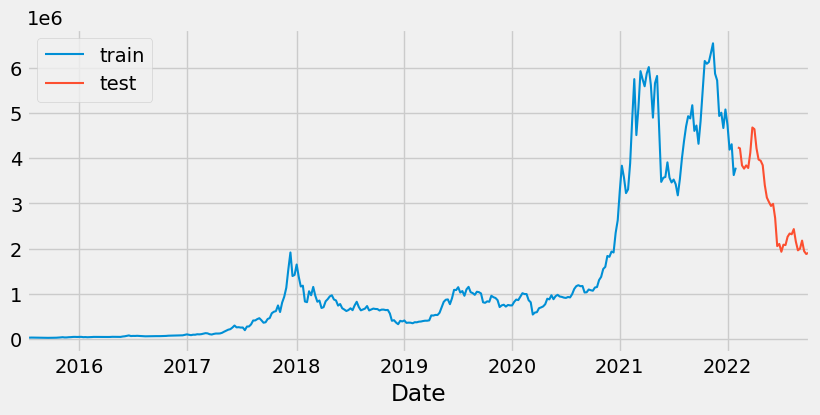

In [287]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend()

With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [288]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-07-12 00:00:00'), Timestamp('2022-01-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-20 18:14:31 
Last fit date: 2022-10-20 18:14:31 
Skforecast version: 0.5.1 
Python version: 3.10.6 

In [289]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-02-06    3.655525e+06
2022-02-13    3.663442e+06
2022-02-20    3.606205e+06
2022-02-27    3.628785e+06
2022-03-06    3.619592e+06
Freq: W-SUN, Name: pred, dtype: float64

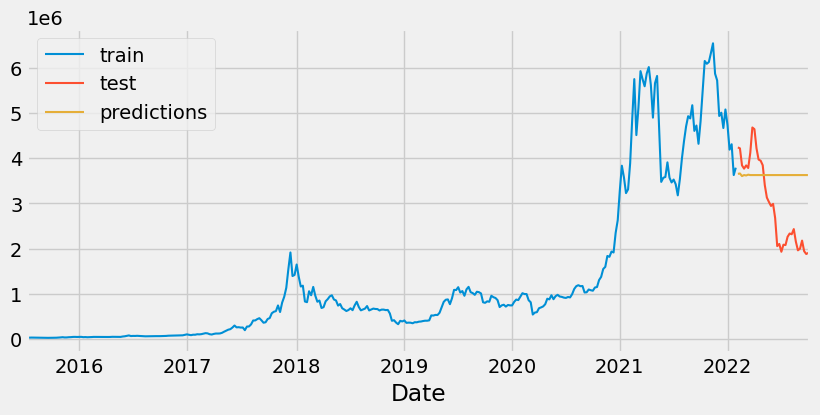

In [290]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [291]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1300750221954.0796


The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable. In order to identify the best combination of lags and hyperparameters, the Skforecast library provides the grid_search_forecaster function. It compares the results obtained with each model configuration.

In [292]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:50<00:00, 25.04s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 2235478402617.0654



In [293]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",2.235478e+12,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",2.244097e+12,3,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",2.246434e+12,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",2.272618e+12,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",2.278374e+12,10,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",2.307545e+12,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",2.313081e+12,5,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",2.316244e+12,10,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",2.323703e+12,3,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",2.325221e+12,5,100


In [294]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 6
             )

forecaster.fit(y=data_train['y'])

In [295]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

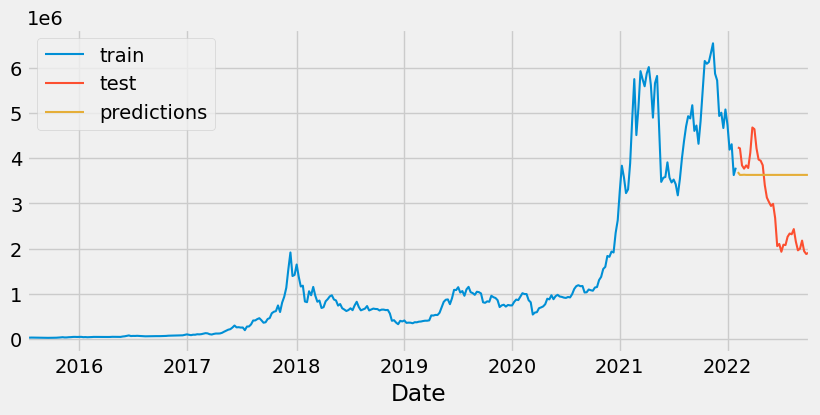

In [296]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [297]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1305475697418.0771


Backtesting with refit and fixed training size (rolling origin)

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

In [298]:
# Backtesting
# ==============================================================================
steps = 24
n_backtesting = 24*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    metric             = 'mean_squared_error',
                                    refit              = True,
                                    verbose            = True
                                )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 307
Number of observations used for backtesting: 72
    Number of folds: 3
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2015-07-12 00:00:00 -- 2021-05-23 00:00:00  (n=307)
    Validation: 2021-05-30 00:00:00 -- 2021-11-07 00:00:00  (n=24)
Data partition in fold: 1
    Training:   2015-07-12 00:00:00 -- 2021-11-07 00:00:00  (n=331)
    Validation: 2021-11-14 00:00:00 -- 2022-04-24 00:00:00  (n=24)
Data partition in fold: 2
    Training:   2015-07-12 00:00:00 -- 2022-04-24 00:00:00  (n=355)
    Validation: 2022-05-01 00:00:00 -- 2022-10-09 00:00:00  (n=24)

Backtest error: 1981490713735.4504


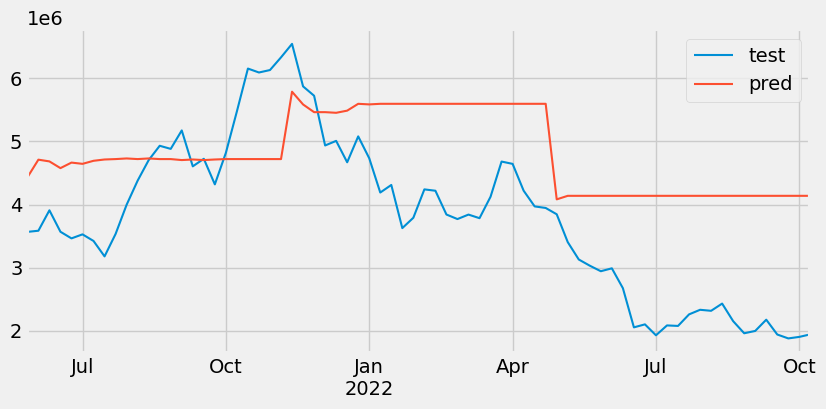

In [299]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [300]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.307955
1,lag_2,0.180886
2,lag_3,0.222724
3,lag_4,0.108617
4,lag_5,0.117064
5,lag_6,0.062755


In [301]:
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2015-07-12 00:00:00 --- 2022-01-30 00:00:00  (n=343)
Test dates  : 2022-02-06 00:00:00 --- 2022-10-09 00:00:00  (n=36)


In [302]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['natr_10'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: natr_10 
Training range: [Timestamp('2015-07-12 00:00:00'), Timestamp('2022-01-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-20 18:15:24 
Last fit date: 2022-10-20 18:15:24 
Skforecast version: 0.5.1 
Python version: 3.10.6 

In [303]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['natr_10'])

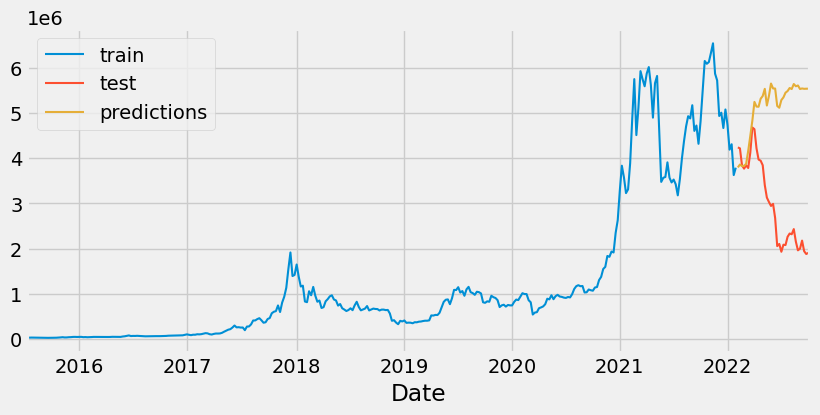

In [304]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [305]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 6634558411112.485


In [306]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    exog        = data_train['natr_10'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 27.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:18<00:00, 26.03s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 2053154181289.2776



In [307]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,max_depth,n_estimators
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 500}",2.053154e+12,5,500
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 10, 'n_estimators': 50}",2.100149e+12,10,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",2.202464e+12,3,50
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",2.210914e+12,5,100
8,"[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 500}",2.216932e+12,10,500


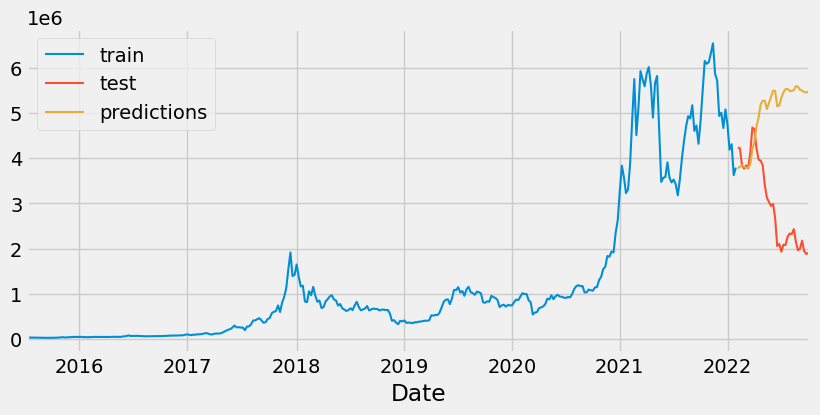

In [308]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['natr_10'])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [309]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 6406805807134.861


In [310]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [311]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Window size: 20 
Transformer for y: None 
Transformer for exog: None 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-07-12 00:00:00'), Timestamp('2022-01-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-20 18:16:45 
Last fit date: 2022-10-20 18:16:45 
Skforecast version: 0.5.1 
Python version: 3.10.6 

In [312]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



In [313]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
Date,,,,,,,,,,,
2015-11-29,32553.601074,32116.598511,37436.801147,32643.099976,28467.999268,26264.300537,24805.000305,23925.900269,23375.700378,23221.200562,27343.775253
2015-12-06,37229.400635,32553.601074,32116.598511,37436.801147,32643.099976,28467.999268,26264.300537,24805.000305,23925.900269,23375.700378,27645.910263
2015-12-13,38978.298950,37229.400635,32553.601074,32116.598511,37436.801147,32643.099976,28467.999268,26264.300537,24805.000305,23925.900269,28221.755142
2015-12-20,43475.500488,38978.298950,37229.400635,32553.601074,32116.598511,37436.801147,32643.099976,28467.999268,26264.300537,24805.000305,28927.100143


In [314]:
y.head(4)

Date
2015-11-29    37229.400635
2015-12-06    38978.298950
2015-12-13    43475.500488
2015-12-20    44368.499756
Freq: W-SUN, Name: y, dtype: float64

In [315]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

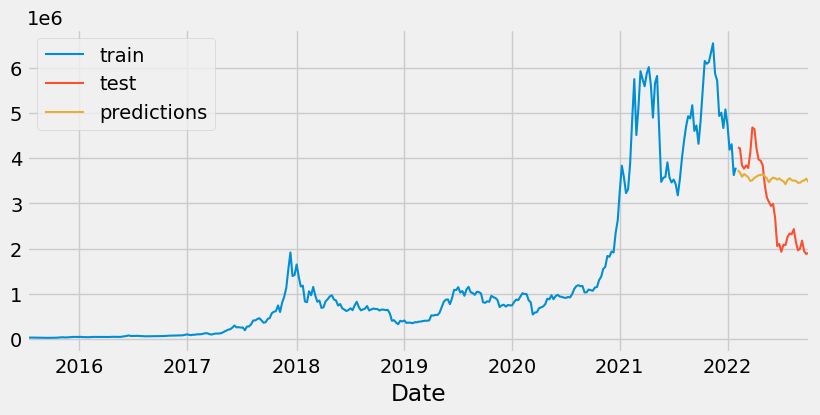

In [316]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [317]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 1119960989498.249


In [318]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['y'],
                    param_grid  = param_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 6.


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:25<00:00, 25.14s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 2198371833939.6555



In [319]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",2.198372e+12,3,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",2.213272e+12,3,500
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",2.292668e+12,10,500
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",2.293767e+12,10,100
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",2.298599e+12,5,100
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",2.300078e+12,5,500


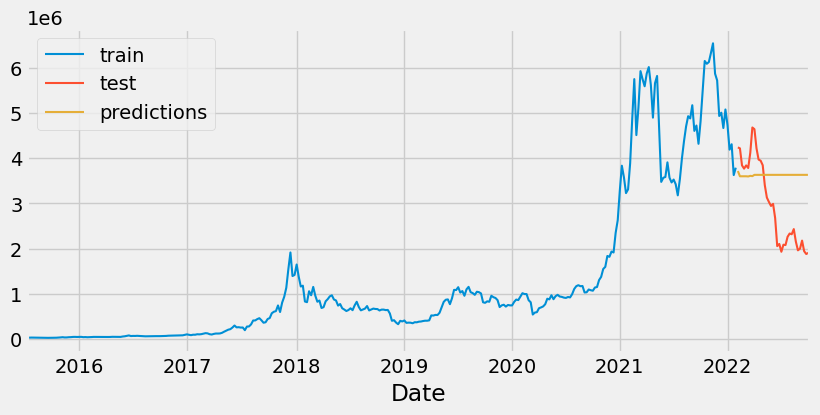

In [320]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [321]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 1310912565586.8389


In [322]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 8 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
Creation date: 2022-10-20 18:17:11 
Last fit date: None 
Skforecast version: 0.5.1 
Python version: 3.10.6 

In [323]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = data_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = True,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(data_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    verbose            = False
                )

Number of models compared: 30.


loop lags_grid:  33%|█████████████                          | 1/3 [00:02<00:04,  2.37s/it]/home/kozan/.virtualenvs/tf_stock/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.177e-02
  model = cd_fast.enet_coordinate_descent(
/home/kozan/.virtualenvs/tf_stock/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.600e-01, tolerance: 1.204e-02
  model = cd_fast.enet_coordinate_descent(
/home/kozan/.virtualenvs/tf_stock/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You mi

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 1e-05}
  Backtesting metric: 2451851368621.825




/home/kozan/.virtualenvs/tf_stock/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.865e-02, tolerance: 2.837e-02
  model = cd_fast.enet_coordinate_descent(


In [324]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,mean_squared_error,alpha
0,"[1, 2, 3, 4, 5]",{'alpha': 1e-05},2.451851e+12,0.000010
1,"[1, 2, 3, 4, 5]",{'alpha': 0.0001291549665014884},2.452895e+12,0.000129
2,"[1, 2, 3, 4, 5]",{'alpha': 0.0016681005372000592},2.457172e+12,0.001668
3,"[1, 2, 3, 4, 5]",{'alpha': 0.021544346900318846},2.692215e+12,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 0.021544346900318846},2.844349e+12,0.021544


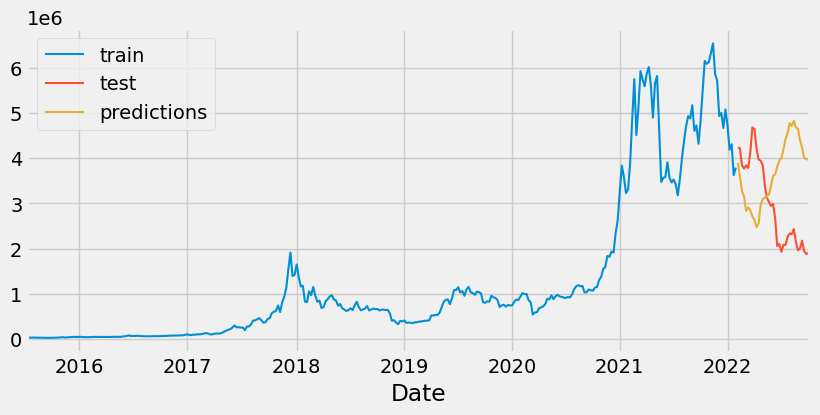

In [325]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [326]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
2022-02-06,3.867235e+06,3.287974e+06,4.698060e+06
2022-02-13,3.657157e+06,2.792293e+06,4.549137e+06
2022-02-20,3.688995e+06,2.710073e+06,4.850180e+06
2022-02-27,3.660322e+06,2.212922e+06,4.833164e+06
2022-03-06,3.701117e+06,2.131047e+06,4.856553e+06


Test error (mse): 1803407027043.4792


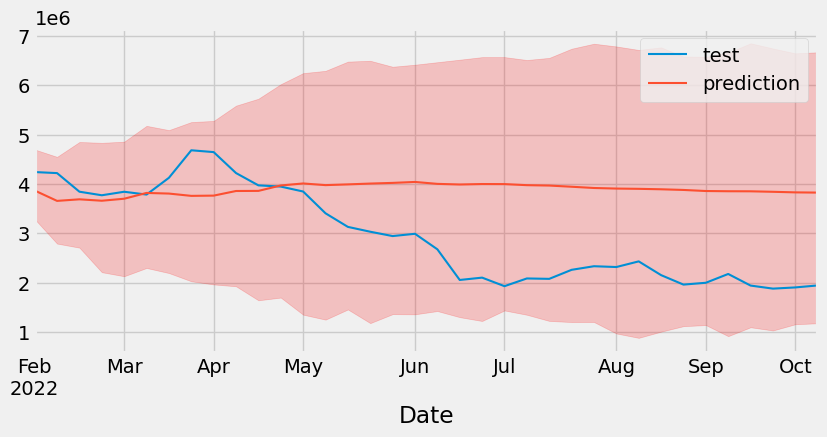

In [327]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

Information of backtesting process
----------------------------------
Number of observations used for initial training: 271
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   2015-07-12 00:00:00 -- 2020-09-13 00:00:00  (n=271)
    Validation: 2020-09-20 00:00:00 -- 2021-05-23 00:00:00  (n=36)
Data partition in fold: 1
    Training:   2015-07-12 00:00:00 -- 2021-05-23 00:00:00  (n=307)
    Validation: 2021-05-30 00:00:00 -- 2022-01-30 00:00:00  (n=36)
Data partition in fold: 2
    Training:   2015-07-12 00:00:00 -- 2022-01-30 00:00:00  (n=343)
    Validation: 2022-02-06 00:00:00 -- 2022-10-09 00:00:00  (n=36)

Test error (mse): 1803407027043.4792


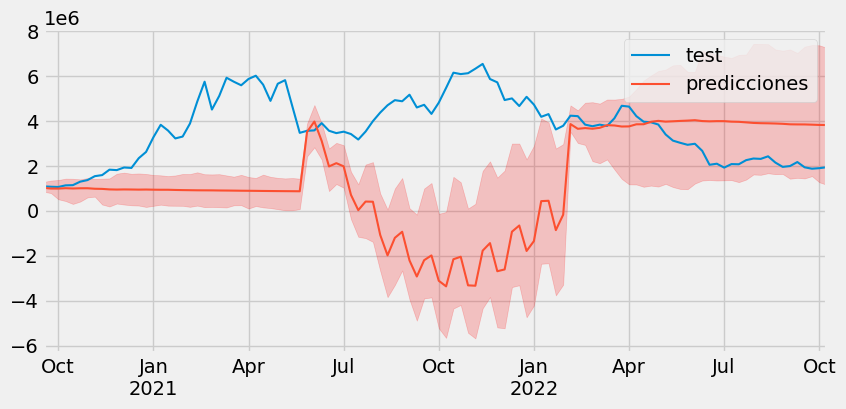

In [328]:
# Backtest with prediction intervals
# ==============================================================================
n_backtesting = 36*3 # The last 9 years are separated for backtesting
steps = 36
forecaster = ForecasterAutoreg(
                regressor = LinearRegression(),
                lags      = 15
             )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                      )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions.index, 'y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [329]:
# Predicted interval coverage
# ==============================================================================
inside_interval = np.where(
                     (data.loc[predictions.index, 'y'] >= predictions['lower_bound']) & \
                     (data.loc[predictions.index, 'y'] <= predictions['upper_bound']),
                     True,
                     False
                   )

coverage = inside_interval.mean()
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

Predicted interval coverage: 41.67 %


In [330]:
# Custom metric 
# ==============================================================================
from sklearn.metrics import mean_absolute_error

def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric

In [331]:
# Backtesting 
# ==============================================================================
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for backtesting

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    verbose            = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 271
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   2015-07-12 00:00:00 -- 2020-09-13 00:00:00  (n=271)
    Validation: 2020-09-20 00:00:00 -- 2021-05-23 00:00:00  (n=36)
Data partition in fold: 1
    Training:   2015-07-12 00:00:00 -- 2021-05-23 00:00:00  (n=307)
    Validation: 2021-05-30 00:00:00 -- 2022-01-30 00:00:00  (n=36)
Data partition in fold: 2
    Training:   2015-07-12 00:00:00 -- 2022-01-30 00:00:00  (n=343)
    Validation: 2022-02-06 00:00:00 -- 2022-10-09 00:00:00  (n=36)

Backtest error: 4097753.0536846323


In [332]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

2022-10-16    2.081625e+06
2022-10-23    2.203922e+06
2022-10-30    2.125301e+06
Freq: W-SUN, Name: pred, dtype: float64

In [333]:
# Save model
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

In [334]:
# Load model
forecaster_loaded = load_forecaster('forecaster.py')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-07-12 00:00:00'), Timestamp('2022-10-09 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-20 18:17:23 
Last fit date: 2022-10-20 18:17:23 
Skforecast version: 0.5.1 
Python version: 3.10.6 



In [335]:
# Predict
forecaster_loaded.predict(steps=3)

2022-10-16    2.081625e+06
2022-10-23    2.203922e+06
2022-10-30    2.125301e+06
Freq: W-SUN, Name: pred, dtype: float64